# CNN On Caffe

- GEMM: General Matrix Multiply 通用矩阵乘

- BLAS: Basic Linear Algebra Subprograms http://www.netlib.org/blas/

- https://juejin.cn/post/6985783184063463438

## GEMM On 图像实现

In [1]:
import numpy as np
import cv2
import sys
import math
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

import logging
FORMAT = '%(levelname)s %(asctime)s - %(message)s'
logging.basicConfig(format=FORMAT, stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger()

DEBUG 2022-05-13 11:05:19,049 - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


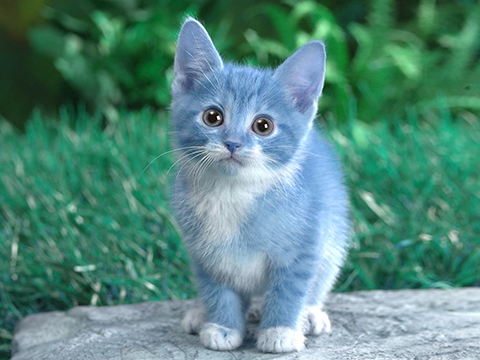

In [2]:
def load_image(path, flags=cv2.IMREAD_UNCHANGED):
    return cv2.imread(path, flags=flags)
   
def show_image(img):
    display(Image.fromarray(img))
    
imgpath = 'data/cat.jpg'
origin_img = load_image(imgpath)
show_image(origin_img)

In [8]:
h, w, c = origin_img.shape
h, w, c

(360, 480, 3)

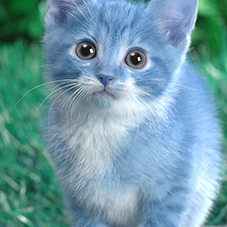

In [9]:
dim = (227, 227)
hh = int(h/2)
hw = int(w/2)
hdh = int(dim[0]/2)
hdw = int(dim[1]/2)
img = origin_img[hh-hdh:hh+hdh+1, hw-hdw:hw+hdw+1]
show_image(img)

In [10]:
h, w, c = img.shape
h, w, c

(227, 227, 3)

In [11]:
kernel=np.array((11, 11))
pad=np.array((0, 0))
stride=np.array((4, 4))
nh = (h - kernel[0] + 2 * pad[0]) / stride[0] + 1
nw = (w - kernel[1] + 2 * pad[1]) / stride[1] + 1
nh, nw, nh*nw

(55.0, 55.0, 3025.0)

In [12]:
# im2col

def im2col(arr, kernel=np.array((3, 3)), pad=np.array((1, 1)), stride=np.array((1, 1))):
    logger.debug(f'kernel = {kernel}, pad = {pad}, stride = {stride}')
    c = 1
    h = arr.shape[0]
    w = arr.shape[1]
    if len(arr.shape) > 2:
        c = arr.shape[2]
    na = []
    for i in range(-pad[0], h+pad[0], stride[0]):
        if (i + kernel[0]) > h:
            break
        logger.debug(i)
        for j in range(-pad[1], w+pad[1], stride[1]):
            if (j + kernel[1]) > w:
                break
            batch = []
            for m in range(kernel[0]):
                im = i + m
                for n in range(kernel[1]):
                    jn = j + n
                    if (im < 0 or im >= h) or (jn < 0 or jn >= w):
                        batch.append([0 for _ in range(c)])
                    else:
                        batch.append(list(arr[im][jn]))
            na.append(batch)
    na = np.array(na, dtype=np.uint8)
    nh, nw, nc = na.shape
    na = np.reshape(na, (nh, nw * nc))
    return na

In [13]:
img_vector = im2col(img, np.array((11, 11)), np.array((0, 0)), np.array((4, 4)))
img_vector.shape

DEBUG 2022-05-13 11:06:38,043 - kernel = [11 11], pad = [0 0], stride = [4 4]
DEBUG 2022-05-13 11:06:38,044 - 0
DEBUG 2022-05-13 11:06:38,058 - 4
DEBUG 2022-05-13 11:06:38,072 - 8
DEBUG 2022-05-13 11:06:38,085 - 12
DEBUG 2022-05-13 11:06:38,099 - 16
DEBUG 2022-05-13 11:06:38,114 - 20
DEBUG 2022-05-13 11:06:38,128 - 24
DEBUG 2022-05-13 11:06:38,175 - 28
DEBUG 2022-05-13 11:06:38,190 - 32
DEBUG 2022-05-13 11:06:38,203 - 36
DEBUG 2022-05-13 11:06:38,217 - 40
DEBUG 2022-05-13 11:06:38,231 - 44
DEBUG 2022-05-13 11:06:38,245 - 48
DEBUG 2022-05-13 11:06:38,258 - 52
DEBUG 2022-05-13 11:06:38,273 - 56
DEBUG 2022-05-13 11:06:38,288 - 60
DEBUG 2022-05-13 11:06:38,302 - 64
DEBUG 2022-05-13 11:06:38,315 - 68
DEBUG 2022-05-13 11:06:38,329 - 72
DEBUG 2022-05-13 11:06:38,343 - 76
DEBUG 2022-05-13 11:06:38,357 - 80
DEBUG 2022-05-13 11:06:38,409 - 84
DEBUG 2022-05-13 11:06:38,423 - 88
DEBUG 2022-05-13 11:06:38,436 - 92
DEBUG 2022-05-13 11:06:38,449 - 96
DEBUG 2022-05-13 11:06:38,463 - 100
DEBUG 2022-05-

(3025, 363)

In [14]:
img_vector

array([[ 17,  60,  33, ...,  12,  65,  25],
       [ 17,  52,  26, ...,  14,  76,  30],
       [ 11,  52,  21, ...,  15,  77,  31],
       ...,
       [120, 144, 142, ..., 114, 140, 146],
       [ 59, 104,  88, ..., 102, 129, 133],
       [ 32,  87,  72, ..., 127, 148, 156]], dtype=uint8)

In [15]:
show_image(img_vector[0].reshape(11, 11, 3))

In [16]:
55 * 55

3025

> batch size: 即min-batch SGD中batch，指一次进入网络的样本数， AlexNet Paper中是96

## mnist

[mnist dataset on lecun website](http://yann.lecun.com/exdb/mnist/)

{'training_images': 'dataset/mnist_lecun/train-images-idx3-ubyte.gz',
 'test_images': 'dataset/mnist_lecun/t10k-images-idx3-ubyte.gz',
 'training_labels': 'dataset/mnist_lecun/train-labels-idx1-ubyte.gz',
 'test_labels': 'dataset/mnist_lecun/t10k-labels-idx1-ubyte.gz'}

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/mnist_lecun/train-images-idx3-ubyte.gz'

In [ ]:
x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)
x_train

In [36]:
!ls

Dockerfile           create_imagenet.sh   mnist.py
__pycache__          create_mnist.sh      models
alexnet.proto        data                 run_docker_python.sh
alexnet.py           get_ilsvrc_aux.sh    scripts
alexnet_pb2.py       get_mnist.sh         test_lenet.sh
classification.py    imagenet             time_lenet.sh
cnn.ipynb            mnist                train_lenet.sh
